In [17]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [18]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [19]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz


In [22]:
from tools.misc_tools import create_Lorenz_data, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data, plot_latent_states, readAndReturnLossHistories
from tools.ae_v4 import Autoencoder

In [23]:
tf.test.gpu_device_name()

''

# Lorenz System

In [24]:
# setting up params
from numpy import *

ae_idx = '004'
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx

with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
    lines = f.readlines()

tparams_dict = eval(''.join(lines))

learning_rate_list = tparams_dict['learning_rate_list']
epochs = tparams_dict['epochs']
patience = tparams_dict['patience']
min_delta = tparams_dict['min_delta']
prng_seed = tparams_dict['prng_seed']
train_split = tparams_dict['train_split']
val_split = tparams_dict['val_split']
batch_size = tparams_dict['batch_size']

test_split = 1 - train_split - val_split
# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

In [25]:
with open(dir_name_ae + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()

params_dict = eval(lines[0])

rho_arr = params_dict['rho_arr']
sigma_arr = params_dict['sigma_arr']
beta_arr = params_dict['beta_arr']

x0 = params_dict['x0']
y0 = params_dict['y0']
z0 = params_dict['z0']

t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']

return_params_arr = params_dict['return_params_arr']
normalize_flag = params_dict['normalize_flag']

In [26]:
res_dict = create_Lorenz_data(
    T, t0, delta_t,
    rho_arr, sigma_arr, beta_arr,
    x0, y0, z0, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [27]:
n = len(boundary_idx_arr)
# # '''
# num_cols = 1
# num_rows = n

# fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

# prev_idx = 0
# for i in range(n):
#     # ax = plt.axes(projection ='3d')
#     next_idx = boundary_idx_arr[i]
    
#     ax_orig = fig.add_subplot(num_rows, num_cols, i+1, projection ='3d')
#     ax_orig.plot(all_data[prev_idx:next_idx, 0], all_data[prev_idx:next_idx, 1], all_data[prev_idx:next_idx, 2])
#     ax_orig.title.set_text(r'Actual Data - [$\sigma$, $\rho$, $\beta$] = ' + str(all_data[next_idx-1, 3:]))
#     ax_orig.set_xlabel('x')
#     ax_orig.set_ylabel('y')
#     ax_orig.set_zlabel('z')
    
#     # ax_predict = fig.add_subplot(num_rows, num_cols, 2*i+2, projection ='3d')
#     # ax_predict.plot(reconstructed_data[prev_idx:next_idx, 0], reconstructed_data[prev_idx:next_idx, 1], reconstructed_data[prev_idx:next_idx, 2])
#     # ax_predict.title.set_text(r'NN Reconstructed Data - [$\sigma$, $\rho$, $\beta$] = ' + str(all_data[next_idx-1, 3:])
#     # )
#     # ax_predict.set_xlabel('x')
#     # ax_predict.set_ylabel('y')
#     # ax_predict.set_zlabel('z')

#     prev_idx = next_idx
# # '''

# Autoencoder

In [28]:
# setting up data
idx = np.arange(all_data.shape[0])
np.random.shuffle(idx)
boundary = int(np.round((1-test_split)*all_data.shape[0]))
training_data = all_data[idx[0:boundary], :]
testing_data = all_data[idx[boundary:], :]

In [29]:
# Training parameters
lambda_reg = 1e-5  # weight for regularizer

# Initialize network
ae_net = Autoencoder(
    data_dim=6,
    enc_layers=[16,12,8,8,4,4,2],
    dec_layers=[2,4,4,8,8,12,16],
    latent_space_dim=2,
    lambda_reg=lambda_reg,
    reg_name='L2',
    enc_layer_act_func='elu',
    enc_final_layer_act_func='tanh',
    dec_layer_act_func='elu',
    dec_final_layer_act_func='linear',
    load_file=None,
    batch_norm=True)

In [30]:
ae_net.load_weights(dir_name_ae+dir_sep+'checkpoints'+dir_sep+'checkpoint')

In [31]:
# with h5py.File(dir_name_ae+'{ds}checkpoints{ds}LossHistoriesCheckpoint.hdf5'.format(ds=dir_sep), 'r') as f:
#     val_loss_arr_fromckpt = np.array(f['val_loss_arr'])
#     train_loss_arr_fromckpt = np.array(f['train_loss_arr'])

# val_loss_hist = []
# train_loss_hist = []
# lr_change=[0]

# num_epochs_left = epochs
# starting_lr_idx = 0
# for i in range(len(learning_rate_list)):
#     nan_flags = np.isnan(val_loss_arr_fromckpt[epochs*i:epochs*(i+1)])
#     if nan_flags[0] == True:
#         # this and all further learning rates were not reached in previous training session
#         break
#     else:
#         temp_ = np.where(nan_flags == False)[0]
#         num_epochs_left = epochs - len(temp_)
#         starting_lr_idx = i

#         val_loss_hist.extend(val_loss_arr_fromckpt[epochs*i:epochs*(i+1)][temp_])
#         train_loss_hist.extend(train_loss_arr_fromckpt[epochs*i:epochs*(i+1)][temp_])
#         lr_change.append(lr_change[i]+len(temp_))

val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
    dir_name_ae=dir_name_ae,
    dir_sep=dir_sep,
    epochs=epochs,
    learning_rate_list=learning_rate_list)

In [32]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[starting_lr_idx]),
    loss=losses.MeanSquaredError()
)

# implementing early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=True,
    min_delta=min_delta
)

# model checkpoint callback
dir_name_ckpt = dir_name_ae+'/checkpoints'
if not os.path.isdir(dir_name_ckpt):
    os.makedirs(dir_name_ckpt)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
    monitor='val_loss',
    save_best_only=True,
    verbose=2,
    save_weights_only=True,
    period=5
)

timekeeper_cb = mytimecallback()

savelosses_cb_vallossarr = val_loss_arr_fromckpt
savelosses_cb_trainlossarr = train_loss_arr_fromckpt
savelosses_cb = SaveLosses(
    filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
    val_loss_arr=savelosses_cb_vallossarr,
    train_loss_arr=savelosses_cb_trainlossarr,
    total_epochs=epochs,
    period=10)


# training the network
for i in range(starting_lr_idx, len(learning_rate_list)):
    learning_rate = learning_rate_list[i]
    K.set_value(ae_net.optimizer.lr, learning_rate)

    savelosses_cb.update_lr_idx(i)

    if i == starting_lr_idx:
        EPOCHS = num_epochs_left
        savelosses_cb.update_offset(epochs-num_epochs_left)
    else:
        EPOCHS = epochs
        savelosses_cb.update_offset(0)

    total_s_len = 80
    sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
    print('\n\n' + '-'*len(sep_lr_s))
    print('\n' + sep_lr_s+'\n')
    print('-'*len(sep_lr_s) + '\n\n')
    
    history = ae_net.fit(training_data, training_data,
        epochs=EPOCHS,
        batch_size=batch_size,
        validation_split=val_split/train_split,
        callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
        verbose=1
    )

    val_loss_hist.extend(history.history['val_loss'])
    train_loss_hist.extend(history.history['loss'])
    
    if i == starting_lr_idx:
        lr_change[i+1] += len(history.history['val_loss'])
    else:
        lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1440
3323/3323 [==============================] - 28s 7ms/step - loss: 0.0902 - val_loss: 0.0972
Epoch 2/1440
3323/3323 [==============================] - 21s 6ms/step - loss: 0.0934 - val_loss: 0.0973
Epoch 3/1440
3323/3323 [==============================] - 21s 6ms/step - loss: 0.0929 - val_loss: 0.0973
Epoch 4/1440
3323/3323 [==============================] - 21s 6ms/step - loss: 0.0901 - val_loss: 0.0972
Epoch 5/1440
3316/3323 [============================>.] - ETA: 0s - loss: 0.0914 - tot_time: 0h 1m 51.3s

Epoch 5: val_loss improved from inf to 0.09727, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/saved_ae/ae_004/checkpoints/checkpoint
3323/3323 [==============================] - 20s 6ms/step - loss: 0.0

844/844 [==============================] - 2s 3ms/step - loss: 0.1819


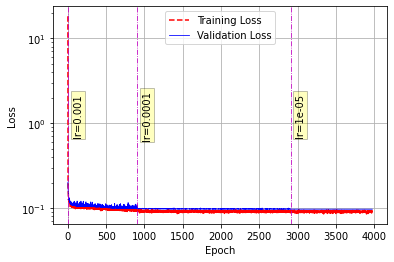

In [33]:
# plotting losses
test_loss = ae_net.evaluate(
    testing_data, testing_data,
)
# lr_change = [0, 987, 987+334]
# for i in range(1,len(lr_change)):
#     lr_change[i] += lr_change[i-1]

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_ae+'/plots/loss_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
reconstructed_data = ae_net.predict(all_data)

In [35]:
fig = plot_reconstructed_data(
    boundary_idx_arr=boundary_idx_arr,
    dir_name_ae=dir_name_ae,
    all_data=all_data,
    reconstructed_data=reconstructed_data,
    save_figs=False)

Output hidden; open in https://colab.research.google.com to view.

In [36]:
plot_reconstructed_data(
    boundary_idx_arr=boundary_idx_arr,
    dir_name_ae=dir_name_ae,
    all_data=all_data,
    reconstructed_data=reconstructed_data,
    save_figs=True)

In [37]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

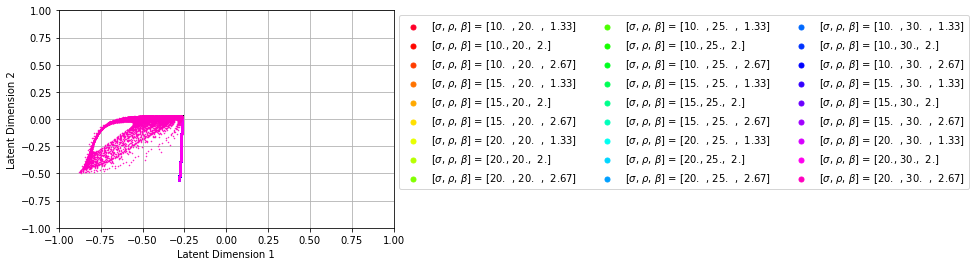

In [38]:
fig, ax = plot_latent_states(
    boundary_idx_arr=boundary_idx_arr,
    latent_states_all=latent_states_all,
    all_data=all_data,
    xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='gist_rainbow',
    legend_markerscale=10
    )

plt.savefig(dir_name_ae + '{ds}plots{ds}latent_space.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')

In [39]:
# ae_net.summary()

In [40]:
save_path = dir_name_ae+dir_sep+'final_net'

if not os.path.isdir(save_path):
    os.makedirs(save_path)

with open(save_path+dir_sep+'losses.txt', 'w') as f:
    f.write(str({
        'val_loss_hist':val_loss_hist,
        'train_loss_hist':train_loss_hist,
        'lr_change':lr_change,
        'test_loss':test_loss,
    }))

ae_net.save_everything(file_name=save_path+dir_sep+'final_net')

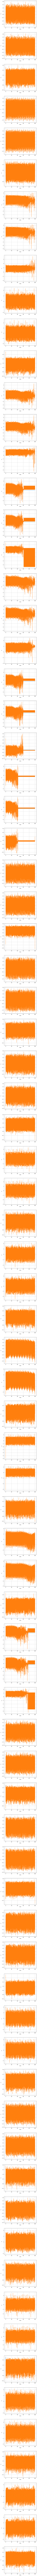

In [41]:
n = len(boundary_idx_arr)
num_cols = 1
num_rows = 3*n

# plt.ion()

fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

Tt = N * delta_t
time_arr = np.arange(0, N+1) * Tt / N

y_labels = [r'$x_1$', r'$x_2$', r'$x_3$']

prev_idx = 0
for i in range(n):
    # ax = plt.axes(projection ='3d')
    next_idx = boundary_idx_arr[i]

    for j in range(3):
        ax = fig.add_subplot(num_rows, num_cols, 3*i+j+1)
        ax.plot(time_arr, all_data[prev_idx:next_idx, j], label='original')
        ax.plot(time_arr, reconstructed_data[prev_idx:next_idx, j], label='reconstructed')
        ax.set_ylabel(y_labels[j])
        ax.set_xlabel('time')
        ax.grid(True)


    prev_idx = next_idx

# LSTM